In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.distributions as D

from clusterless.utils import NP1DataLoader, ADVIDataLoader, fit_initial_gmm
from clusterless.advi import ADVI

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [4]:
np1_data_loader = NP1DataLoader(
    probe_id = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943', 
    geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/np1_channel_map.npy', 
    ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtraction_results_threshold_5', 
    behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
)

Session ID: db4df448-e449-4a6f-a0e7-288711e7a75a
Probe ID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 (probe00)
First trial stimulus onset time: 40.81 sec
Last trial stimulus onset time: 2252.10 sec


In [5]:
trials = np1_data_loader.load_spike_features(region='po')

Found 64 channels in region po


In [6]:
trials[0].max(0)

array([  41.8045632 ,  253.        ,  102.79711151, 2591.44347277,
         31.50055122])

In [7]:
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = \
    np1_data_loader.load_behaviors('dynamic')

In [8]:
advi_data_loader = ADVIDataLoader(
                         data = trials, 
                         behavior = wheel_velocity, 
                         n_t_bins = 30)

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf_train_ids = []
kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(advi_data_loader.behavior)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [10]:
i = 0
train_trials, train_trial_ids, train_time_ids, test_trials, test_trial_ids, test_time_ids = \
    advi_data_loader.split_train_test(kf_train_ids[i], kf_test_ids[i])

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
train_trials.max(0)

array([ 253.        ,  119.81131744, 2640.73096908,   44.32273483])

In [12]:
gmm = fit_initial_gmm(np.vstack([train_trials, test_trials]))

Channel 92 is split into 1 modes
Channel 93 is split into 1 modes
Channel 94 is split into 1 modes
Channel 95 is split into 1 modes
Channel 96 is split into 1 modes
Channel 97 is split into 1 modes
Channel 98 is split into 1 modes
Channel 99 is split into 2 modes
Channel 100 is split into 1 modes
Channel 101 is split into 2 modes
Channel 102 is split into 1 modes
Channel 103 is split into 1 modes
Channel 104 is split into 1 modes
Channel 105 is split into 1 modes
Channel 106 is split into 1 modes
Channel 107 is split into 1 modes
Channel 108 is split into 1 modes
Channel 109 is split into 1 modes
Channel 110 is split into 1 modes
Channel 111 is split into 1 modes
Channel 112 is split into 1 modes
Channel 113 is split into 1 modes
Channel 114 is split into 1 modes
Channel 115 is split into 1 modes
Channel 116 is split into 2 modes
Channel 117 is split into 1 modes
Channel 118 is split into 1 modes
Channel 119 is split into 1 modes
Channel 120 is split into 1 modes
Channel 121 is split i

In [13]:
s = torch.tensor(train_trials[:,1:])
y = torch.tensor(advi_data_loader.behavior)
ks = torch.tensor(train_trial_ids)
ts = torch.tensor(train_time_ids)

Nk = len(advi_data_loader.train_ids)
Nt = advi_data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]
print(Nc)

86


#### CAVI-SGD

In [14]:
batch_size = 1
batch_ids = list(zip(*(iter(advi_data_loader.train_ids),) * batch_size))

In [15]:
advi = ADVI(batch_size, Nt, Nc, Nd, gmm.means_, gmm.covariances_)
optim = torch.optim.Adam(advi.parameters(), lr=1e-2)

In [16]:
%%time
max_iter = 3
elbos = []
N = s.shape[0]
for i in range(max_iter):
    tot_elbo = 0
    for n, batch_idx in enumerate(batch_ids): 
        mask = torch.logical_and(ks >= batch_idx[0], ks <= batch_idx[-1])
        batch_s = s[mask]
        batch_y = y[list(batch_idx)]
        batch_ks = ks[mask]
        batch_ts = ts[mask]
        loss = - advi(batch_s, batch_y, batch_ks, batch_ts) / N
        loss.backward()
        tot_elbo -= loss.item()
        if (n+1) % 100 == 0:
            print(f'iter: {i+1} batch {n+1}')
        optim.step()
        optim.zero_grad()
    print(f'iter: {i+1} total elbo: {tot_elbo:.2f}')
    elbos.append(tot_elbo)

iter: 1 batch 100
iter: 1 total elbo: -33.03
iter: 2 batch 100
iter: 2 total elbo: -18.22
iter: 3 batch 100
iter: 3 total elbo: -15.06
CPU times: user 3min 58s, sys: 11.2 s, total: 4min 9s
Wall time: 31.2 s


In [17]:
elbos = [elbo for elbo in elbos]

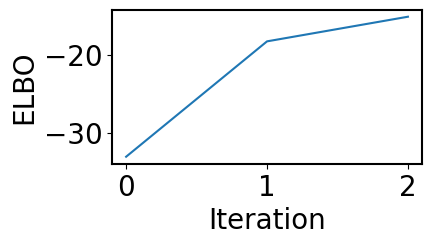

In [18]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [22]:
log_lambdas = torch.zeros((Nk, Nc, Nt))
for k in range(Nk):
    for t in range(Nt):
        log_lambdas[k,:,t] = advi.b.loc + advi.beta.loc[:,t] * y[k][t]

log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]

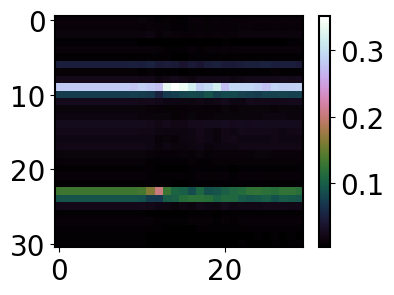

In [23]:
plt.figure(figsize=(4,3))
plt.imshow(torch.exp(log_pis.mean(0)).detach().numpy(), 
           aspect='auto', cmap='cubehelix')
plt.colorbar();

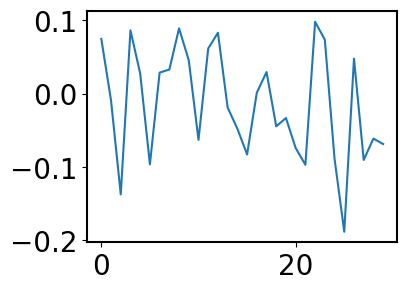

In [24]:
plt.figure(figsize=(4,3))
plt.plot(advi.beta.loc[1].detach().numpy());

In [25]:
# cont_y_enc_res = {
#     'bs': advi.b.loc,
#     'betas': advi.beta.loc,
#     'means': advi.means,
#     'covs': advi.covs
# }
# np.save(save_path + f'dy_009_cont_y_enc_res_c{Nc}.npy', cont_y_enc_res)

#### MoG only

In [26]:
all_trials = np.concatenate(np.concatenate(data_loader.trials))[:,1:]
spike_times = data_loader.data[:,0]

spike_labels = []
spike_probs = []
spike_labels.extend(gmm.predict(all_trials))
spike_probs.extend(gmm.predict_proba(all_trials))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [27]:
enc_gmm = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    data_loader.stim_on_times,
    'clusterless', 
    n_time_bins=data_loader.n_t_bins
)
print(enc_gmm.shape)

(265, 31, 30)


In [28]:
train = data_loader.train_ids
test = data_loader.test_ids

In [29]:
x_train = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[train]
x_test = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [30]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = -0.017
MSE = 1.854
corr = 0.387


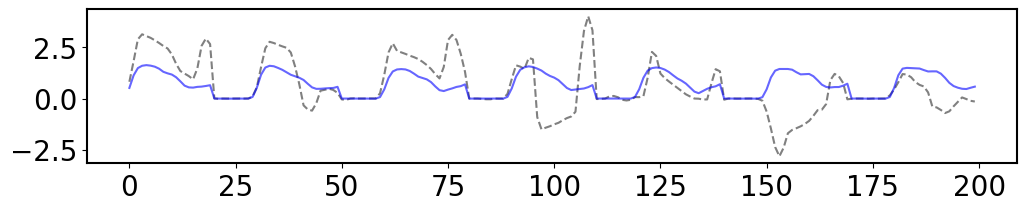

In [31]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[-200:], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[-200:], c='blue', alpha=.6, label='predicted');

In [32]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel 
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.661 seconds
R2 = -0.099
MSE = 2.041
corr = 0.289


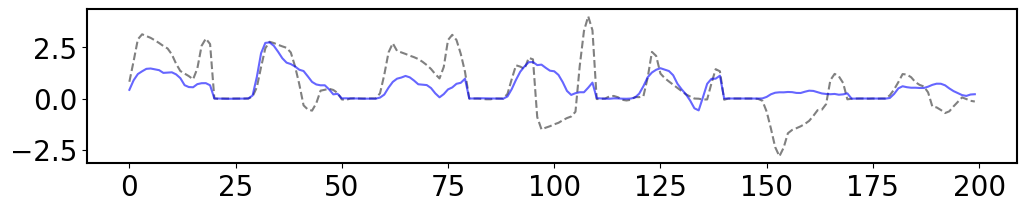

In [33]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[-200:], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[-200:], c='blue', alpha=.6, label='predicted');

In [34]:
windowed_enc_gmm, half_window_size, n_windows = decoder.sliding_window(
    enc_gmm, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [35]:
x_by_trial = windowed_enc_gmm.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_gmm.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_gmm.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=1000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [36]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.032
MSE = 2.348
corr = 0.195


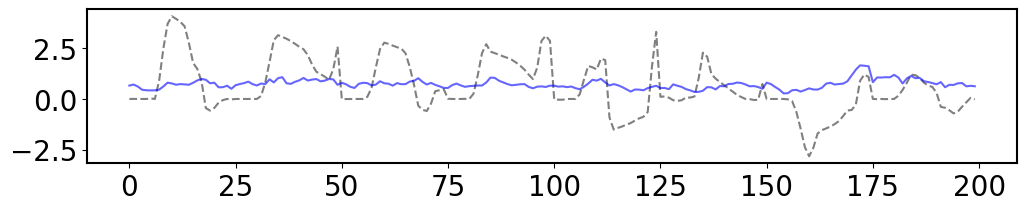

In [37]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[-200:], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[-200:], c='blue', alpha=.6, label='predicted');

#### encoding MoG

In [38]:
n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    # regional=True
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (265, 384, 30)


In [39]:
x_train = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[train]
x_test = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [40]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = -0.004
MSE = 1.821
corr = 0.408


In [41]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel #+ irregularities_kernel + noise_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 3.460 seconds
R2 = -0.048
MSE = 1.881
corr = 0.379


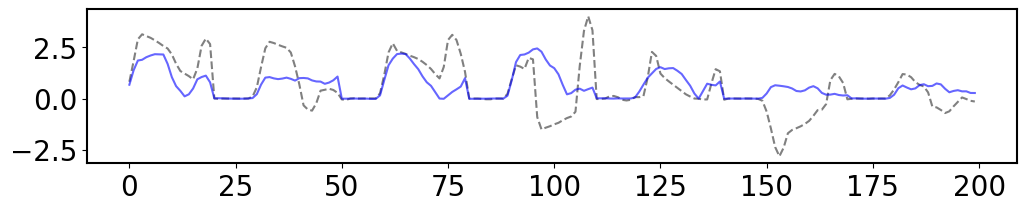

In [42]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[-200:], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[-200:], c='blue', alpha=.6, label='predicted');

In [43]:
log_lambdas_hat = np.zeros((data_loader.n_trials, Nc, Nt))
for i, k in enumerate(train):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = advi.b.loc.detach().numpy() + advi.beta.loc[:,t].detach().numpy() * y_train[i][t]

for i, k in enumerate(test):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = advi.b.loc.detach().numpy() + advi.beta.loc[:,t].detach().numpy() * y_hat[i][t]

log_pis_hat = log_lambdas_hat - logsumexp(log_lambdas_hat, 1)[:,None,:]

In [44]:
enc_pis = np.exp(log_pis_hat)
enc_means = advi.means.detach().numpy()
enc_covs = advi.covs.detach().numpy()

In [45]:
enc_all = np.zeros((data_loader.n_trials, Nc, Nt))

for k in range(enc_all.shape[0]):
    for t in range(Nt):
        enc_gmm =  GaussianMixture(n_components=Nc, covariance_type='full')
        enc_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        enc_gmm.weights_ = enc_pis[k,:,t]
        enc_gmm.means_ = enc_means
        enc_gmm.covariances_ = enc_covs
        if len(data_loader.trials[k][t]) > 0:
            enc_all[k,:,t] = enc_gmm.predict_proba(data_loader.trials[k][t][:,1:]).sum(0)

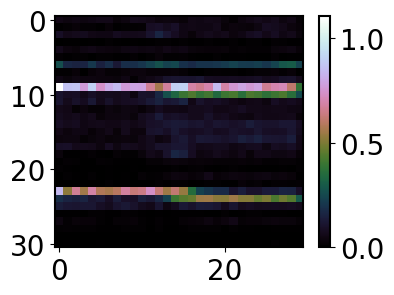

In [46]:
plt.figure(figsize=(4,3))
plt.imshow(enc_all.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

In [47]:
x_train = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[train]
x_test = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [48]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = -0.002
MSE = 1.815
corr = 0.412


In [49]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel 
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.632 seconds
R2 = -0.042
MSE = 1.848
corr = 0.400


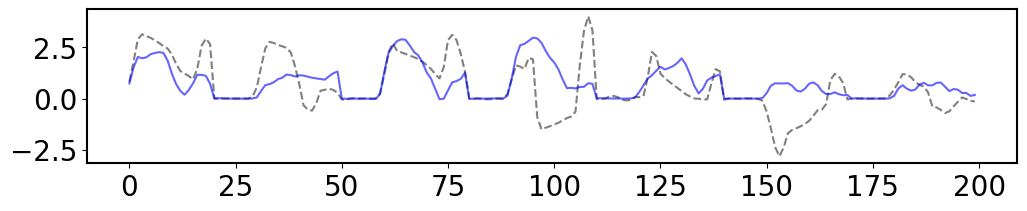

In [50]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[-200:], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[-200:], c='blue', alpha=.6, label='predicted');

In [51]:
windowed_enc_all, half_window_size, n_windows = decoder.sliding_window(
    enc_all, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [52]:
x_by_trial = windowed_enc_all.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_all.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_all.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [53]:
ridge = Ridge(alpha=1000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [54]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.037
MSE = 2.335
corr = 0.199


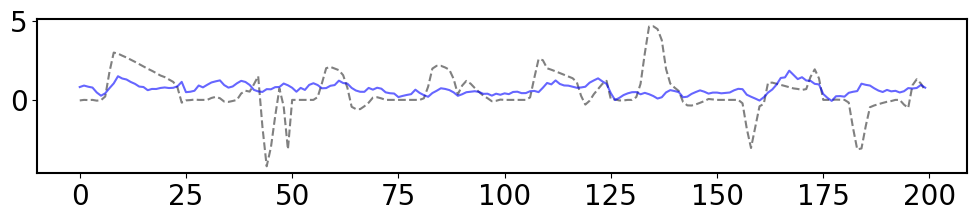

In [55]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### thresholded

In [56]:
windowed_thresh, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [57]:
x_by_trial = windowed_thresh.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_thresh.shape[1]))
x_test = x_test.reshape((-1, windowed_thresh.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [58]:
ridge = Ridge(alpha=1000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [59]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.048
MSE = 2.308
corr = 0.222


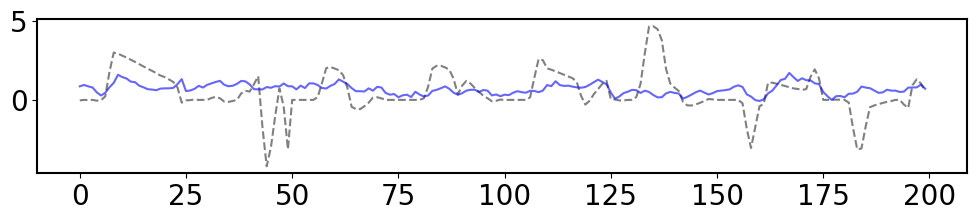

In [60]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### KS & good IBL units

In [61]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 29 neurons in region vis ...
found 28 channels in region vis ...
sorted neural data shape: (265, 509, 30)
good sorted neural data shape: (265, 6, 30)


In [62]:
x_train = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[train]
x_test = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [63]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.002
MSE = 1.814
corr = 0.412


In [64]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=10.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.1**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = (
    long_term_trend_kernel + noise_kernel + irregularities_kernel # + seasonal_kernel 
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 24.189 seconds
R2 = -0.001
MSE = 1.813
corr = 0.412


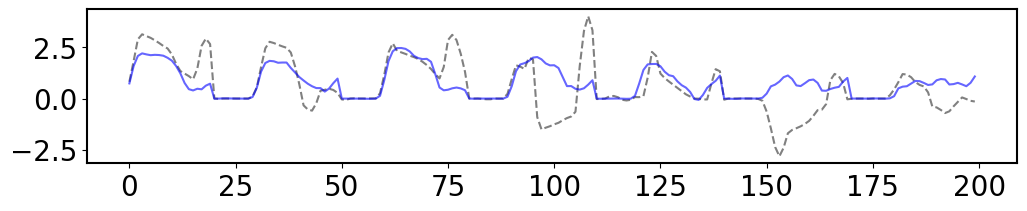

In [65]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[-200:], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[-200:], c='blue', alpha=.6, label='predicted');

In [66]:
windowed_sorted, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)

windowed_good_units, half_window_size, n_windows = decoder.sliding_window(
    good_sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [67]:
x_by_trial = windowed_sorted.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_sorted.shape[1]))
x_test = x_test.reshape((-1, windowed_sorted.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=1000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [68]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.106
MSE = 2.167
corr = 0.347


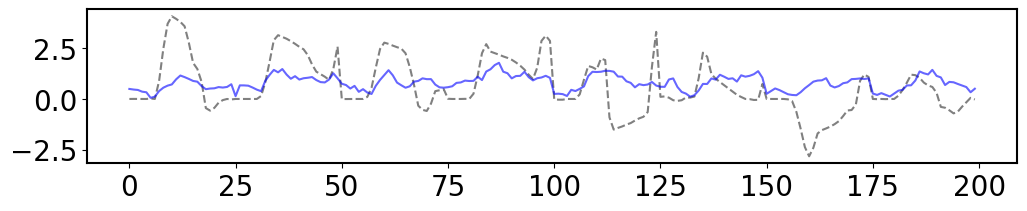

In [69]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[-200:], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[-200:], c='blue', alpha=.6, label='predicted');

In [70]:
x_train = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[train]
x_test = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [71]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = -0.005
MSE = 1.825
corr = 0.406


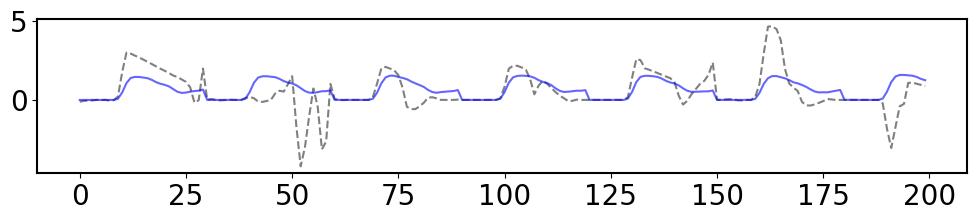

In [72]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [73]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.397 seconds
R2 = -0.030
MSE = 1.860
corr = 0.388


In [74]:
x_by_trial = windowed_good_units.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_good_units.shape[1]))
x_test = x_test.reshape((-1, windowed_good_units.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=1000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [75]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.071
MSE = 2.253
corr = 0.306


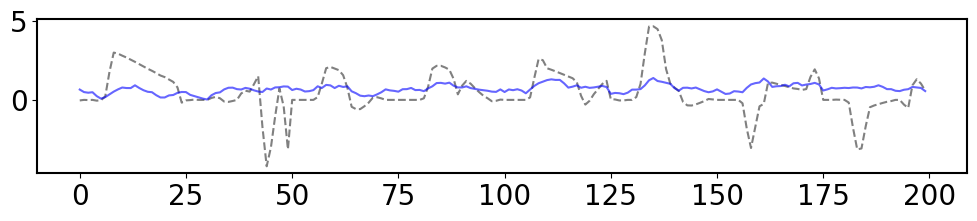

In [76]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');